# Luminometer Shutter Stress Test

### Background
This stress test was conducted from the evening of Friday, August 20th to the morning of Monday, August 23.

Ilakkiyan took three devices #(1, 4, 8) with him home. Rafael took the remaining devices with him #(2, 6, 8, 9). Two devices #(5, 10) were left in the 40C degree oven. 

5 samples were collected per open/close period (as opposed to the usual 20) to reduce the raw data file sizes.

### Analysis below

1. The raw data is read in by channel (column 0 is A, column 1 is B). There are two parameters at the start (start, end) which can be changed to pick out a particular region of the raw data if desired. The raw data is plotted.

2. Every 5 points are averaged to get a single open/close data point. 

3. The difference is taken (np.diff()) between adjacent averaged points. This gives a pattern of positive-negative-positive-negative... where the sign of the number (+/-) corresponds to either an open or close period, respectively.

4. Using the difference array, every even value (should) be a positive value --> open period. Every odd value (should) be a negative value --> close period.
    - If for example, an open period has a negative value, this means that the five points that were averaged to generate that open period datapoint _were lower_ than the preceding five data points averaged to make the closed-shutter datapoint. Vice versa for a positive closed-period datapoint. 
    - I count the number of "true open" / "true closed" / "false open" / "false closed" datapoints and report those as percentages. 
    
5. TODO: This current analysis is naive and does not account for cases where the shutter may have only opened partially, or may not have closed fully. When I tried to do a first pass at detecting outliers using 2/3 STDs, I still wasn't able to pick out true anomalies. 


### Running the notebook 
1. The first cell just sets up the analysis (stress_test_analysis(luminometer_number: int)
2. The second cell loops through the available keys in the dictionary ("shutter_test") and calls the analysis for each. You can just call the function with a single luminometer number if you only want to analyze/view that single data set. 

In [485]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

shutter_test = {
    1: "Luminometer_1/Coupled/STRESS-TEST-2021-Aug-20-21:32:15.csv",
    2: "Luminometer_2/Coupled/STRESS-TEST-2021-Aug-20-23:51:22.csv",
    4: "Luminometer_4/Coupled/STRESS-TEST-2021-Aug-20-23:45:09.csv",
    5: "Luminometer_5/Coupled/STRESS-TEST-2021-Aug-20-23:39:08.csv",
    6: "Luminometer_6/Coupled/STRESS-TEST-2021-Aug-21-00:07:22.csv",
    7: "Luminometer_7/Coupled/STRESS-TEST-2021-Aug-20-23:58:11.csv",
    8: "Luminometer_8/Coupled/STRESS-TEST-2021-Aug-20-21:32:17.csv",
    9: "Luminometer_9/Coupled/STRESS-TEST-2021-Aug-20-23:59:29.csv",
    10: "Luminometer_10/Coupled/STRESS-TEST-2021-Aug-21-00:02:36.csv"
}

def stress_test_analysis(luminometer_number):
    filename = shutter_test[luminometer_number]
    start = 0
    end = -1
    data = pd.read_csv(filename, header=None)[start:end]
    print(f"Luminometer {luminometer_number}")

    for channel in range(2):
        plt.figure(figsize=(15, 3))
        ch = data.iloc[:, channel]
        ab = "A" if channel == 0 else "B"
        
        # Each open/close period consists of 5 measurements
        # Note normally there are 20 points, but to reduce the file
        # size for the stress test, only every fourth point is recorded
        n = 5
        max_index = (len(ch) // n) * n
        ch = ch[:max_index]
        
        # Original data
#         plt.subplot(2, 2, 1)
        plt.title(f"Raw data - Luminometer {luminometer_number} | Channel - {ab}")
        plt.plot(ch, 'o', markersize=0.1)
        
        # Last 40 points of raw
        plt.figure(figsize=(15, 5))
        plt.subplot(2, 2, 1)
        plt.title(f"Last 100 points of raw data")
        plt.plot(ch[-100:], 'o', markersize=1)
        
        # Reshape array to a series of columns each of length n, then average along those columns
        vals = np.average(ch.to_numpy().reshape(-1, n), axis=1)
        
        # Averaged data
        plt.subplot(2, 2, 2)
        plt.title("Raw data - averaging every 5 points - last 20 points")
        plt.plot(vals[-20:], 'o', markersize=1)
        
        # Difference between adjacent values
        diffs = np.diff(vals)
        open_vals = diffs[0::2]
        closed_vals = diffs[1::2]
        
        plt.figure(figsize=(15, 5))
        plt.subplot(2, 2, 1)
        plt.plot(diffs[-20:], markersize=1.1, label="Last 20 open/close periods")
        plt.title(f"Difference between adjacent averaged points - Luminometer {luminometer_number} | Channel {ab}")
        plt.legend()
        
        
        total_open = len(open_vals)
        total_closed = len(closed_vals)
        print(f"Total open/close periods: {total_open} / {total_closed}")
        
        num_true_open = np.count_nonzero(open_vals > 0)
        perc_true_open = num_true_open / total_open * 100
        
        num_false_open = np.count_nonzero(open_vals <= 0)
        perc_false_open = num_false_open / total_open * 100
        
        num_true_closed = np.count_nonzero(closed_vals < 0)
        perc_true_closed = num_true_closed / total_closed * 100
        
        num_false_closed = np.count_nonzero(closed_vals >= 0)
        perc_false_closed = num_false_closed / total_closed * 100
        
        print(f"Channel\t{ab}")
        print(f"True open:\t{num_true_open} / {perc_true_open:.2f}%")
        print(f"False open:\t{num_false_open} / {perc_false_open:.2f}%")
        
        print(f"True closed:\t{num_true_closed} / {perc_true_closed:.2f}%")
        print(f"False closed:\t{num_false_closed} / {perc_false_closed:.2f}%")
        
        plt.subplot(2, 2, 2)
        plt.title(f"% Correct Open/Close Periods - Luminometer {luminometer_number} | Channel {ab}")
        r1 = plt.bar(["Open>closed", "Open<closed"], [perc_true_open, perc_false_open])
        r2 = plt.bar(["Closed<open", "Closed>=open"], [perc_true_closed, perc_false_closed])
        
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                plt.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                        '%% %.3f' % height,
                        ha='center', va='bottom')
        autolabel(r1)
        autolabel(r2)
        
        '''
        Finding outliers via standard deviation doesn't seem to be picking out 
        actually anomalous data points (i.e ones where the shutter is not fully open/close)
        Commented out for now, need a better method (discuss with team). The above stats only account for cases where 
        the shutter is blatantly incorrect - for example when samples collected during an open period average
        out to a smaller value than the preceding closed shutter period.
        '''
#         ### Outliers based on standard deviation
#         num_deviations = 4 # 1=68, 2=95, 3=99.7, 4=99.9
        
#         # Open periods
# #         open_vals_diff = np.diff(open_vals)
#         open_vals_diff = open_vals
#         mean = np.mean(open_vals_diff)
#         std = np.std(open_vals_diff)
#         low = mean - num_deviations*std
#         high = mean + num_deviations*std
#         outside_std = open_vals_diff[(open_vals_diff < low) | (open_vals_diff > high)]
#         num_outside_2std = np.count_nonzero(outside_std)
#         print(f"Open period outliers ({num_deviations} std):\t{num_outside_2std} / {num_outside_2std/len(open_vals_diff)*100:.2f}%")
        
#         # Closed periods
# #         closed_vals_diff = np.diff(closed_vals)
#         closed_vals_diff = closed_vals
#         mean = np.mean(closed_vals_diff)
#         std = np.std(closed_vals_diff)
#         low = mean - num_deviations*std
#         high = mean + num_deviations*std
#         outside_std = closed_vals_diff[(closed_vals_diff < low) | (closed_vals_diff > high)]
#         num_outside_2std = np.count_nonzero(outside_std)
#         print(f"Closed period outliers ({num_deviations} std):\t{num_outside_2std} / {num_outside_2std/len(closed_vals_diff)*100:.2f}%")
#         print("=====\n")
        
#         # Get and plot a random closed period outlier
#         indices = np.argwhere((open_vals_diff<low) | (open_vals_diff>high))
#         rand_indexes = np.random.choice(indices.reshape(-1), size=2)
#         for rand_index in rand_indexes:
#             ri = np.argwhere(indices == rand_index)[0][0]
#             print(rand_index)
#             print(indices[ri-5:ri+5])
#             plt.figure(figsize=(15, 5))
#             start = rand_index - 50
#             end = rand_index + 50
#             plt.title("Example open period outlier")
#             plt.plot(range(start, end), open_vals_diff[start:end])
#             plt.plot(rand_index, open_vals_diff[rand_index], "*", color="C3", markersize=10)
#             plt.figure(figsize=(15, 5))
#             plt.plot(range(start, end), open_vals[start:end], 'o', markersize=5, label="Open")
#             plt.plot(rand_index+1, open_vals[rand_index+1], "*", markersize=15)
#             plt.plot(range(start, end), closed_vals[start:end], 'o', markersize=5, label="Closed")
#             plt.legend()
        plt.tight_layout()        
        plt.show()

Luminometer 1
Total open/close periods: 97371 / 97371
Channel	A
True open:	97355 / 99.98%
False open:	16 / 0.02%
True closed:	97361 / 99.99%
False closed:	10 / 0.01%


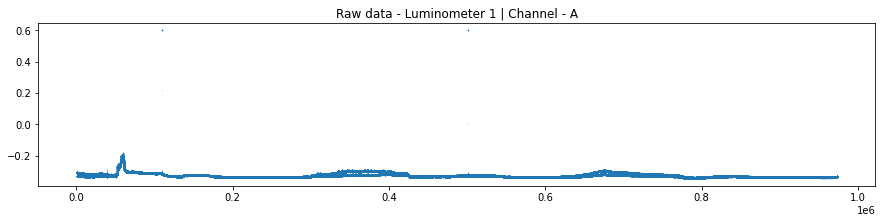

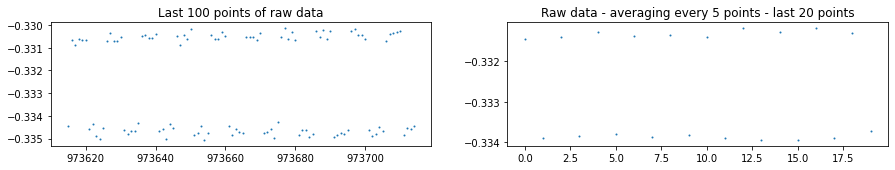

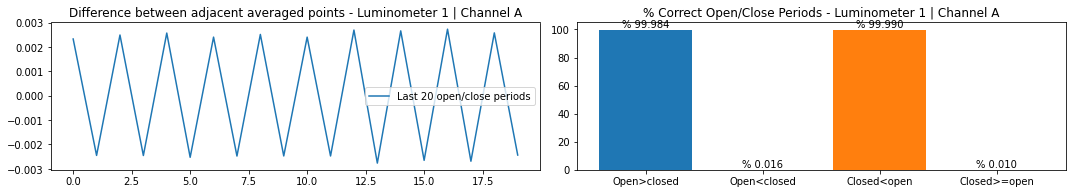

Total open/close periods: 97371 / 97371
Channel	B
True open:	97356 / 99.98%
False open:	15 / 0.02%
True closed:	97361 / 99.99%
False closed:	10 / 0.01%


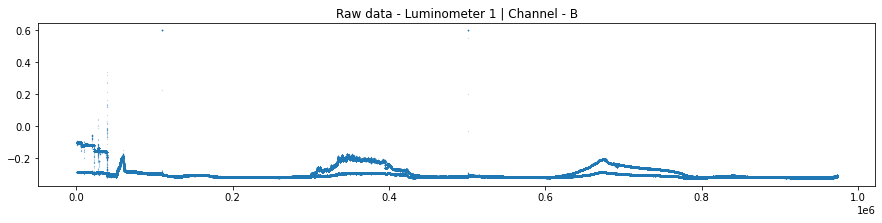

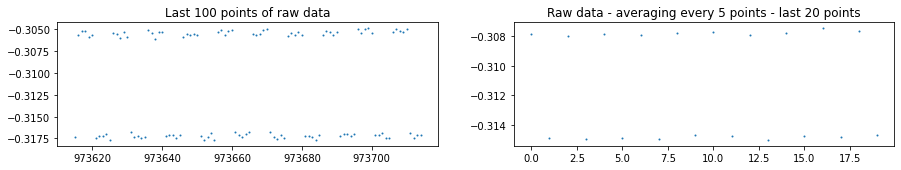

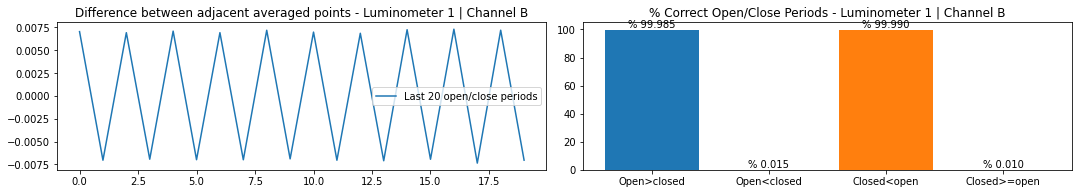

Luminometer 2
Total open/close periods: 96178 / 96178
Channel	A
True open:	95845 / 99.65%
False open:	333 / 0.35%
True closed:	95852 / 99.66%
False closed:	326 / 0.34%


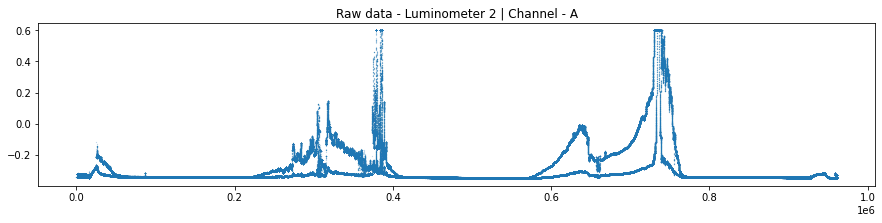

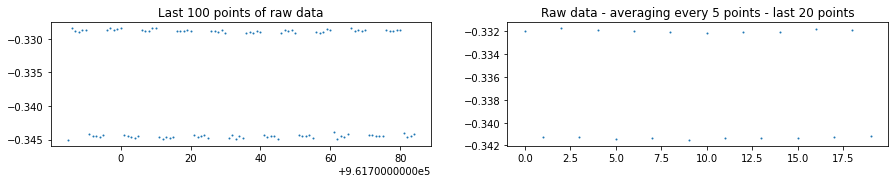

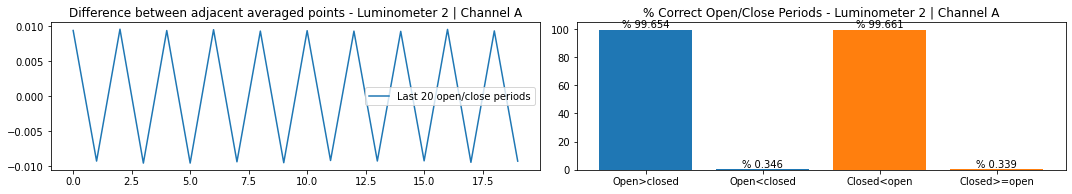

Total open/close periods: 96178 / 96178
Channel	B
True open:	95764 / 99.57%
False open:	414 / 0.43%
True closed:	95776 / 99.58%
False closed:	402 / 0.42%


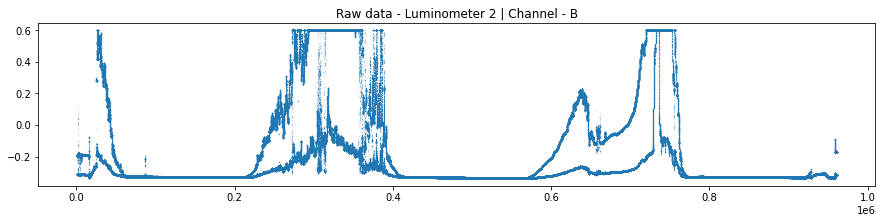

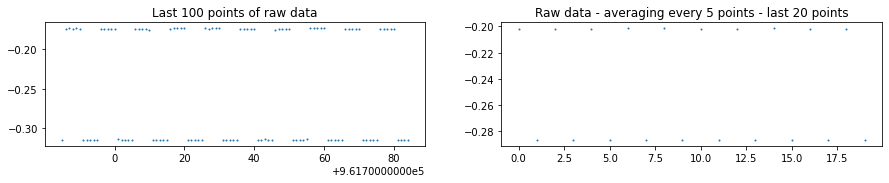

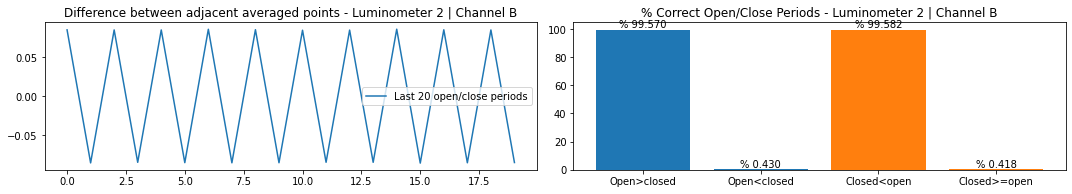

Luminometer 4
Total open/close periods: 93795 / 93794
Channel	A
True open:	93290 / 99.46%
False open:	505 / 0.54%
True closed:	93275 / 99.45%
False closed:	519 / 0.55%


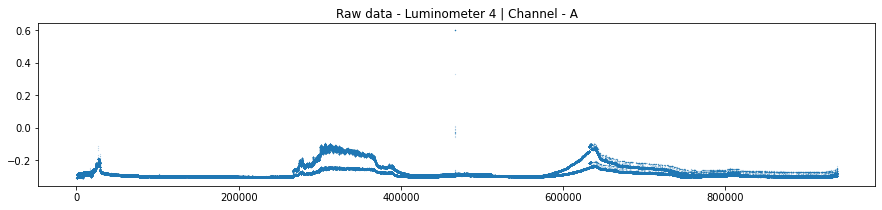

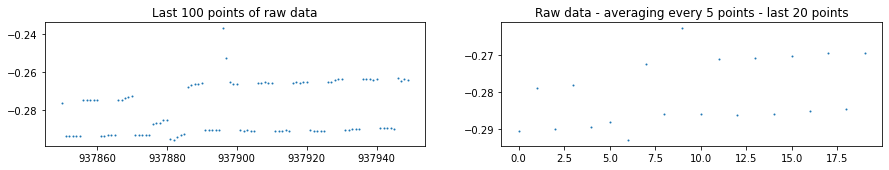

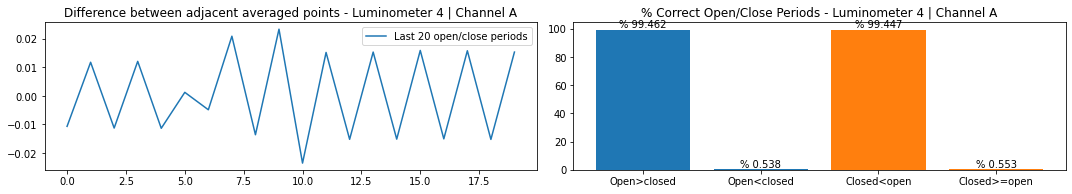

Total open/close periods: 93795 / 93794
Channel	B
True open:	93774 / 99.98%
False open:	21 / 0.02%
True closed:	93779 / 99.98%
False closed:	15 / 0.02%


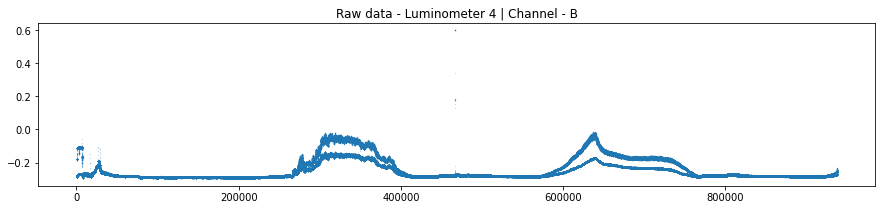

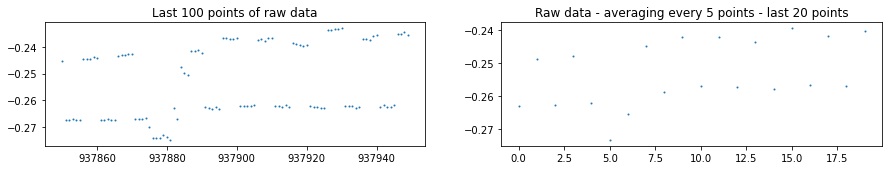

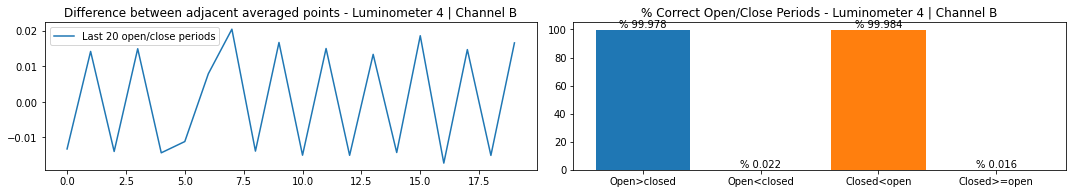

Luminometer 5
Total open/close periods: 94952 / 94951
Channel	A
True open:	88304 / 93.00%
False open:	6648 / 7.00%
True closed:	88166 / 92.85%
False closed:	6785 / 7.15%


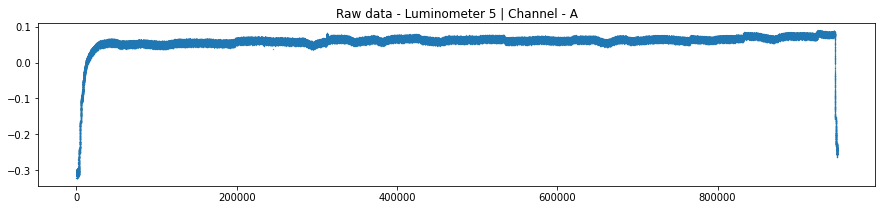

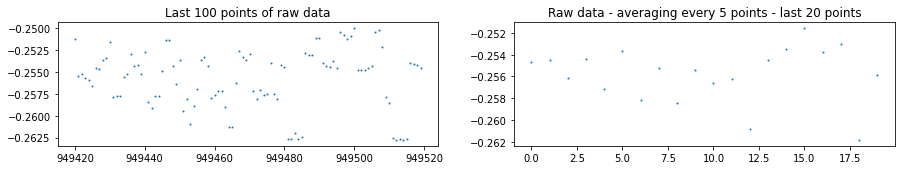

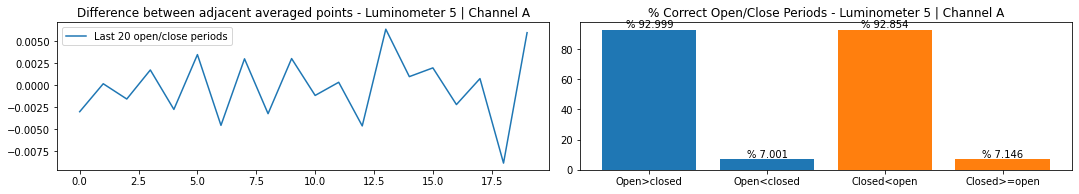

Total open/close periods: 94952 / 94951
Channel	B
True open:	94827 / 99.87%
False open:	125 / 0.13%
True closed:	94830 / 99.87%
False closed:	121 / 0.13%


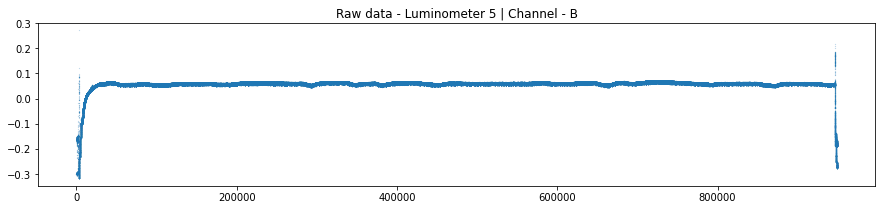

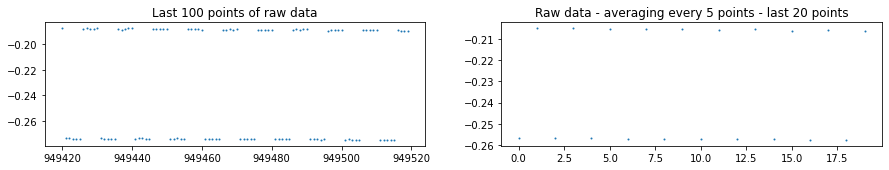

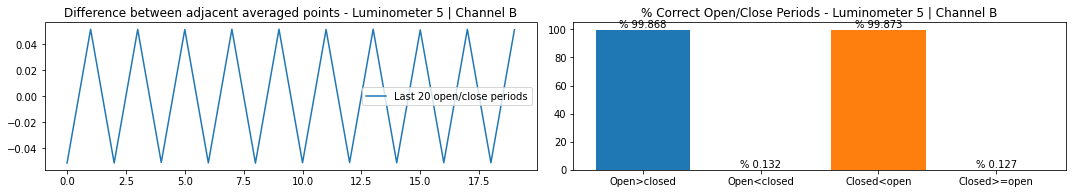

Luminometer 6
Total open/close periods: 64851 / 64850
Channel	A
True open:	64850 / 100.00%
False open:	1 / 0.00%
True closed:	64849 / 100.00%
False closed:	1 / 0.00%


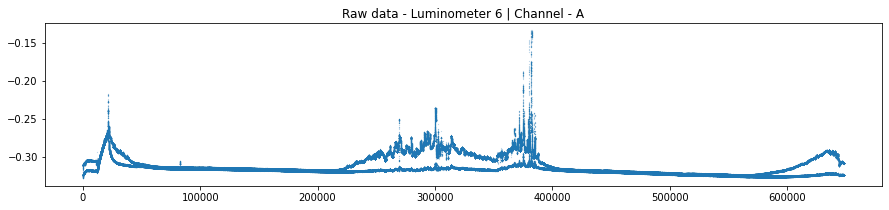

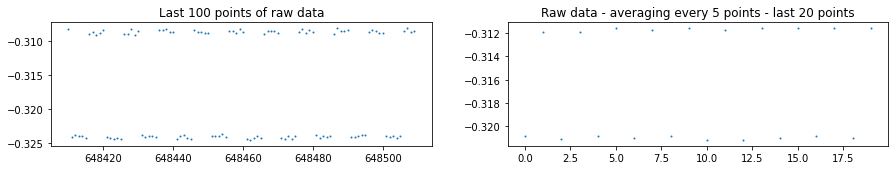

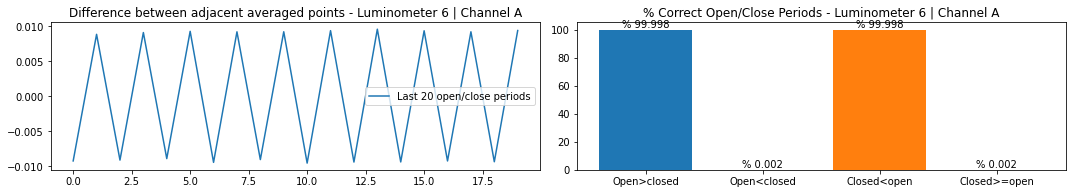

Total open/close periods: 64851 / 64850
Channel	B
True open:	64836 / 99.98%
False open:	15 / 0.02%
True closed:	64845 / 99.99%
False closed:	5 / 0.01%


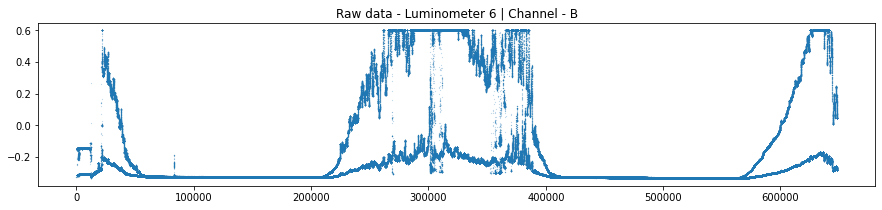

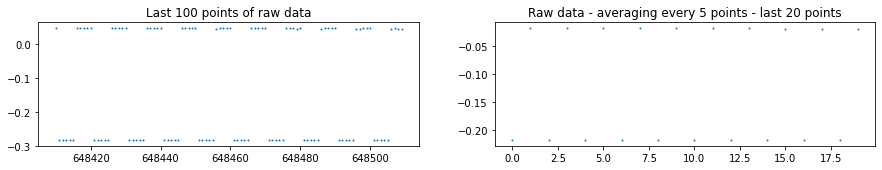

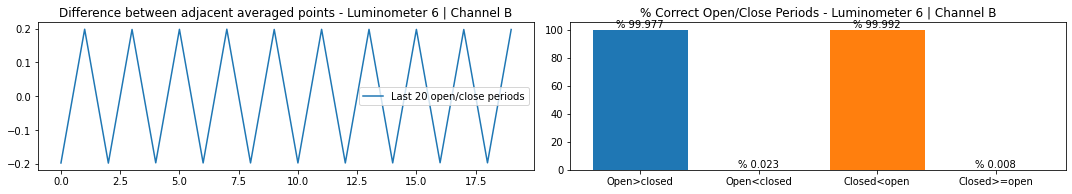

Luminometer 7
Total open/close periods: 96377 / 96376
Channel	A
True open:	96295 / 99.91%
False open:	82 / 0.09%
True closed:	96281 / 99.90%
False closed:	95 / 0.10%


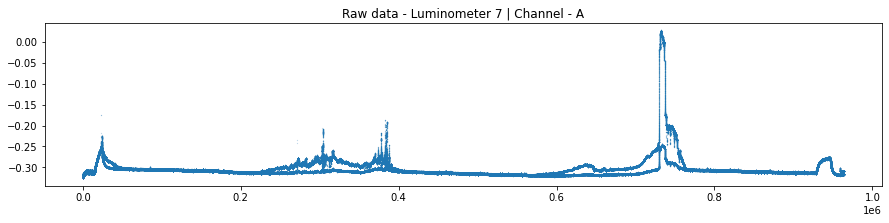

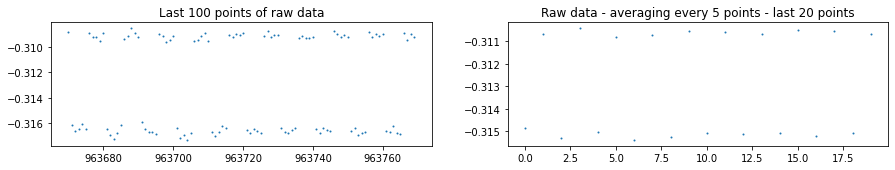

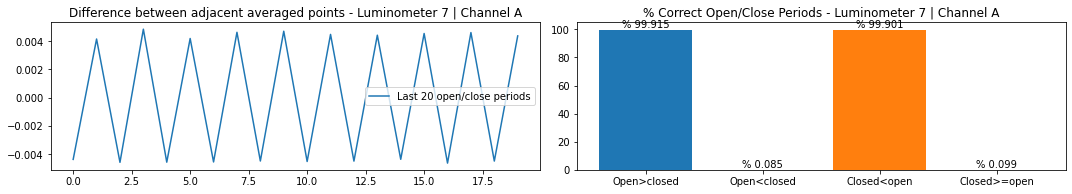

Total open/close periods: 96377 / 96376
Channel	B
True open:	95307 / 98.89%
False open:	1070 / 1.11%
True closed:	95311 / 98.89%
False closed:	1065 / 1.11%


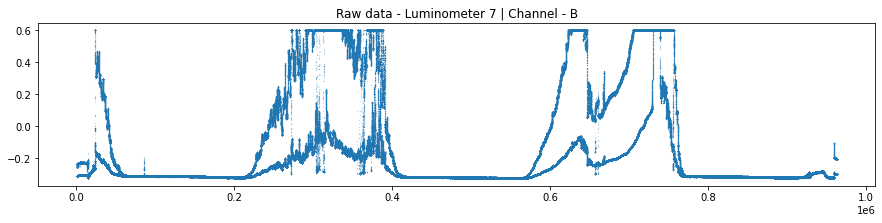

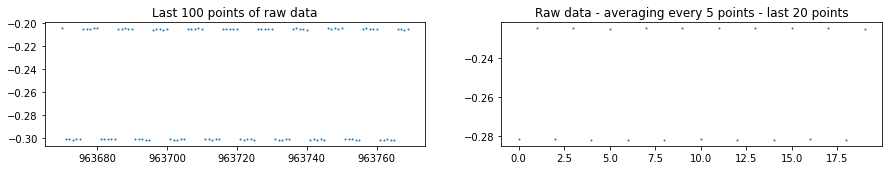

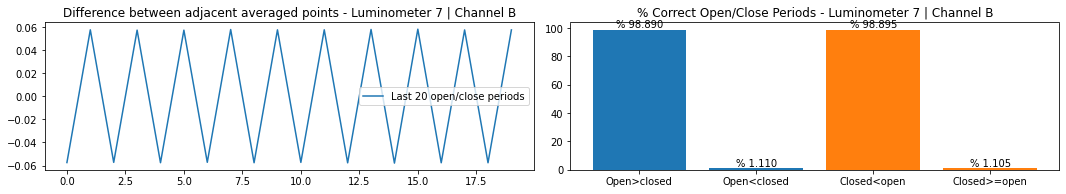

Luminometer 8
Total open/close periods: 97397 / 97396
Channel	A
True open:	97270 / 99.87%
False open:	127 / 0.13%
True closed:	97198 / 99.80%
False closed:	198 / 0.20%


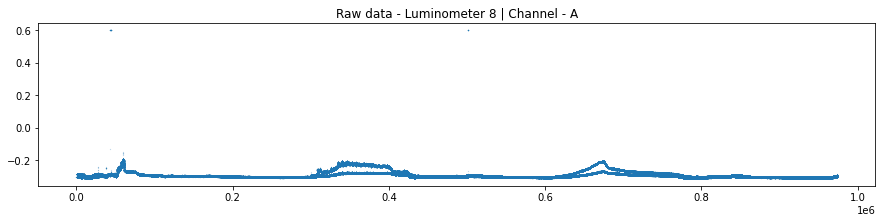

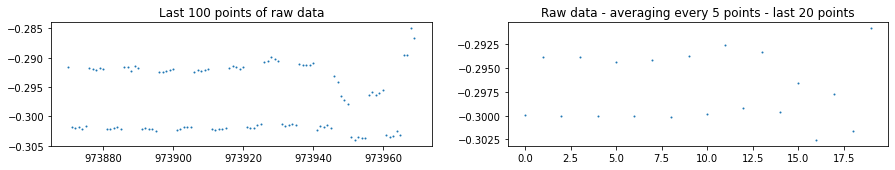

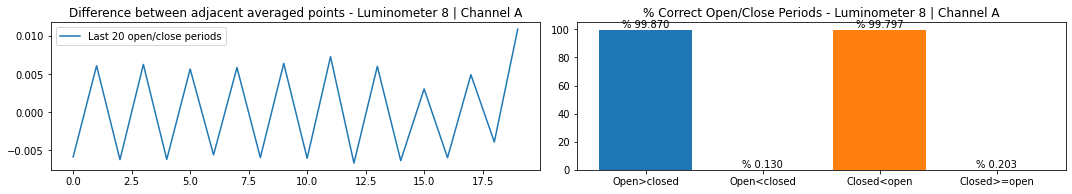

Total open/close periods: 97397 / 97396
Channel	B
True open:	97213 / 99.81%
False open:	184 / 0.19%
True closed:	97221 / 99.82%
False closed:	175 / 0.18%


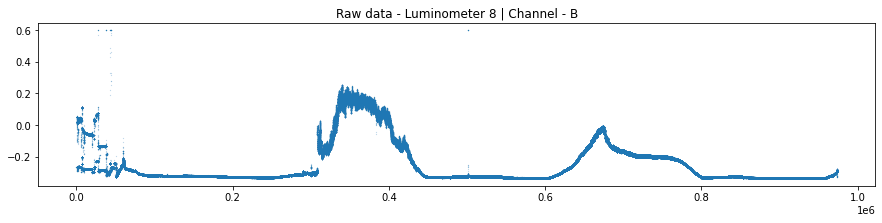

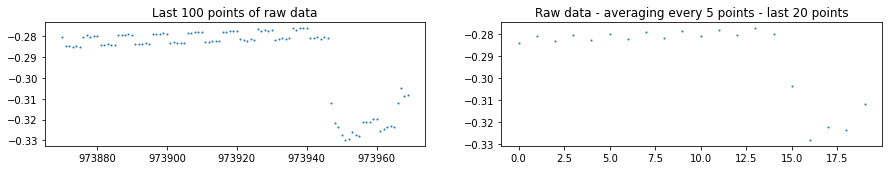

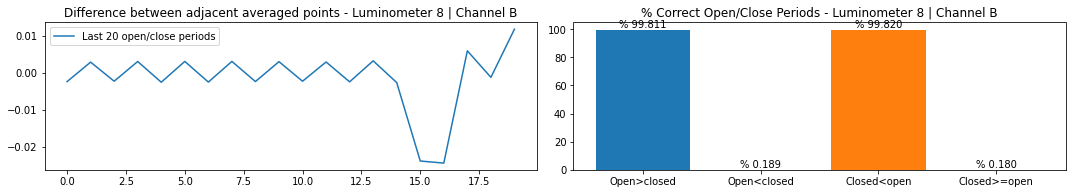

Luminometer 9
Total open/close periods: 96359 / 96358
Channel	A
True open:	96354 / 99.99%
False open:	5 / 0.01%
True closed:	96355 / 100.00%
False closed:	3 / 0.00%


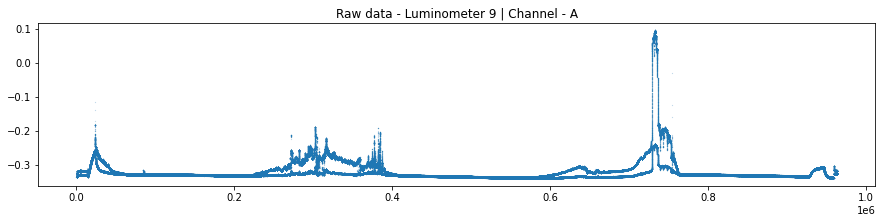

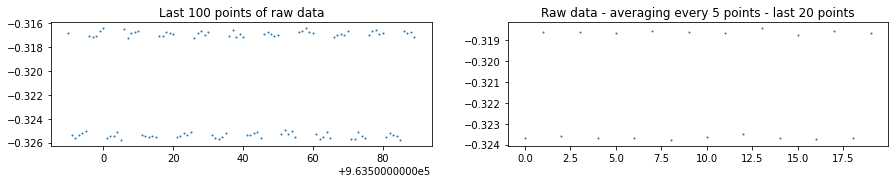

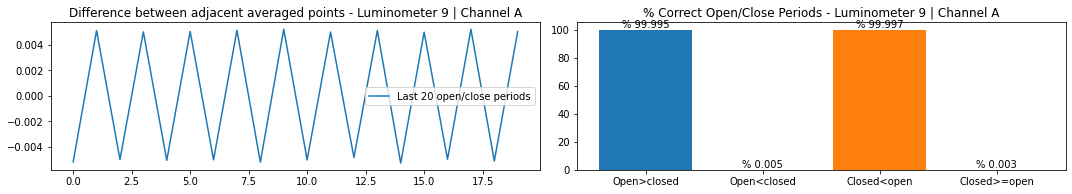

Total open/close periods: 96359 / 96358
Channel	B
True open:	95609 / 99.22%
False open:	750 / 0.78%
True closed:	95616 / 99.23%
False closed:	742 / 0.77%


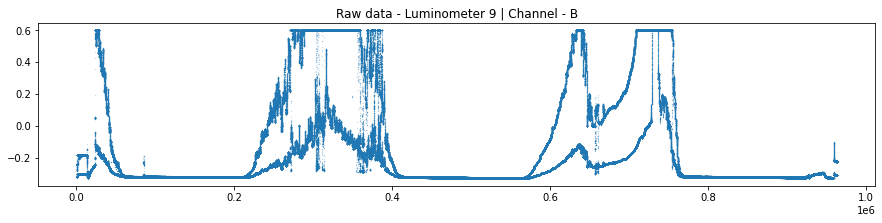

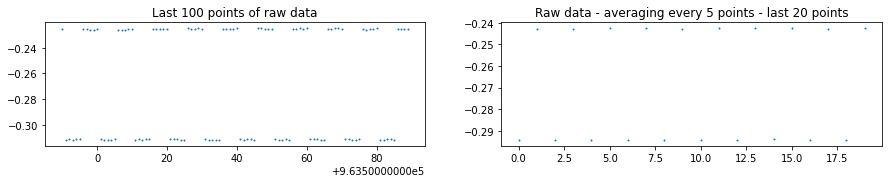

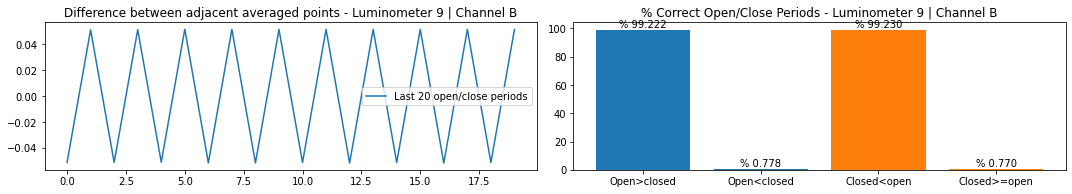

Luminometer 10
Total open/close periods: 97149 / 97149
Channel	A
True open:	95961 / 98.78%
False open:	1188 / 1.22%
True closed:	95937 / 98.75%
False closed:	1212 / 1.25%


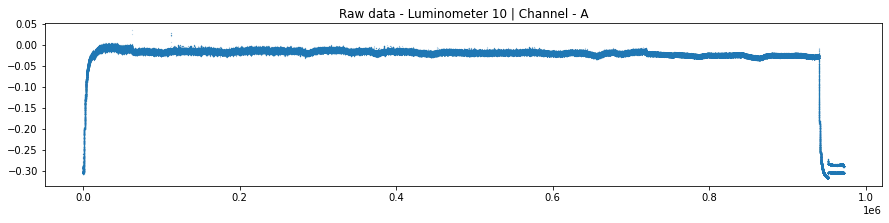

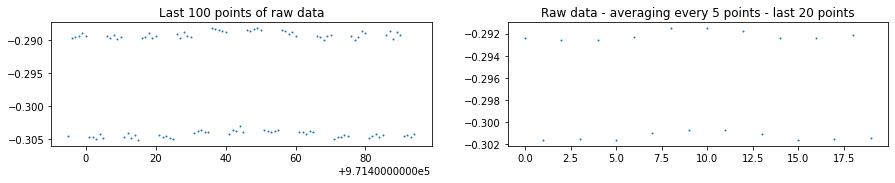

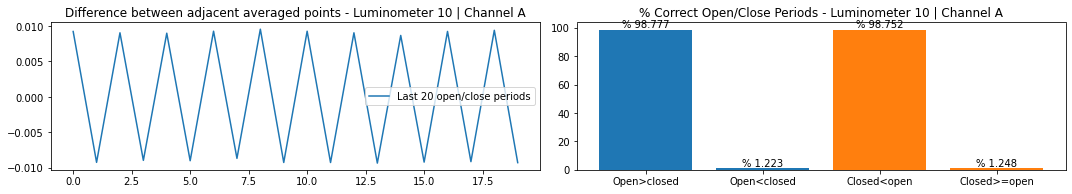

Total open/close periods: 97149 / 97149
Channel	B
True open:	97144 / 99.99%
False open:	5 / 0.01%
True closed:	97147 / 100.00%
False closed:	2 / 0.00%


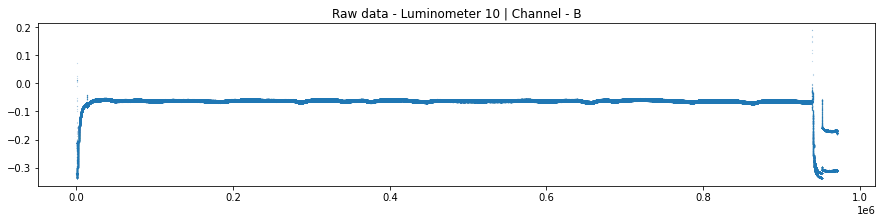

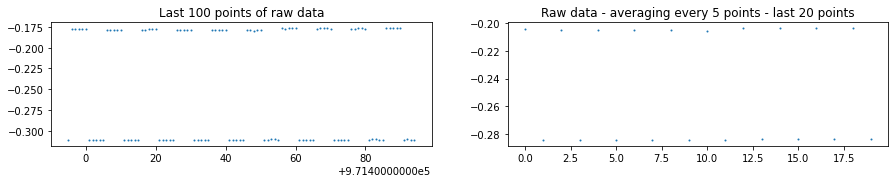

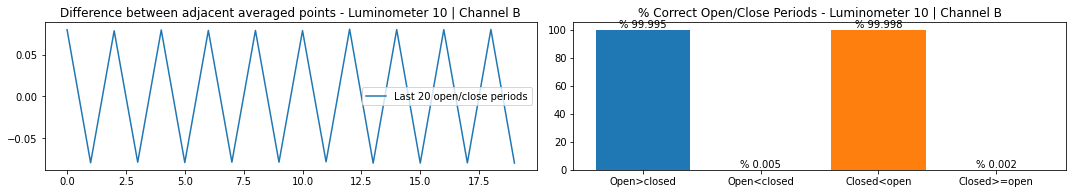

In [486]:
for luminometer in shutter_test.keys():
    stress_test_analysis(luminometer)
# luminometer = 5
# stress_test_analysis(luminometer)